# Irfan Rahmanindra - G2504917A
# IN6227-2023-Assignment-1
## Data Preprocessing

##      Library Imported

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, 
    RocCurveDisplay, roc_auc_score, make_scorer,roc_auc_score, precision_recall_curve, auc
)
from sklearn.model_selection import GridSearchCV

###     1. Data Loading
####    1.1 Define Columns for adult.data and adult.test

In [2]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

###        1.2 Load data in PandaFrame with appropriate data column 
####        - Flag missing value with "?"
####        - Test data skip header rows

In [3]:
train = pd.read_csv('../data/raw/adult.data', names=columns, na_values='?', skipinitialspace=True)
test = pd.read_csv('../data/raw/adult.test', names=columns, na_values='?', skipinitialspace=True, skiprows=1)

###     Checking Total Empty data

In [4]:
train.isnull().sum()
test.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

###     2. Handle Missing Value 
####    2.1 Remove empty value in rows to ensure clean dataset

In [5]:
train = train.dropna()
test = test.dropna() 

###     Rechecking Total Empty data

In [6]:
train.isnull().sum()
test.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## 3. Data Cleaning

#### 3.1 Column “fnlwgt” removed, cause irrelevant to income

In [7]:
train = train.drop('fnlwgt', axis=1)
test = test.drop('fnlwgt', axis=1)

#### 3.2 Remove extra dots from the labels in the test data to match training dataset format

In [8]:
train['income'] = train['income'].str.replace('.', '', regex=False)
test['income'] = test['income'].str.replace('.', '', regex=False) 

###	3.3 Separate column into text and number type. To ensure every feature type has appropriate process

In [9]:
categorical = train.select_dtypes(include=['object']).columns.drop('income')
numerical = train.select_dtypes(include=['int64', 'float64']).columns

## 4. Data Preprocessing
###	4.1 Create Pipeline to process column. Use one-hot encoding to turn text columns into numbers.
### 4.2 Adjust number column to same scale. To help model learn better and faster

In [10]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

### Save cleaned data so it can be reuse

In [11]:
train.to_csv('../data/processed/adult_train_clean.csv', index=False)
test.to_csv('../data/processed/adult_test_clean.csv', index=False)

####    - For Logisitic Regression -> max_iter = 1000 (Ensure Convergence)
####    - For Random Forest -> n_estimator = 100 (Balance Performance and Compute Cost)

In [12]:
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

##      5. Model Setup
###     5.1 Choosing Classification: Logistic Regression and Random Forest
###     5.2 Hyperparameter Tuning

In [ ]:
# Logistic Regression hyperparameter grid
param_grid_lr = {
    'clf__C': [0.1, 1, 10],  
    'clf__class_weight': [None, 'balanced']  
}

f1_scorer = make_scorer(f1_score, pos_label='>50K')

grid_search_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=3, scoring=f1_scorer, n_jobs=-1, verbose=1)  
grid_search_lr.fit(train.drop('income', axis=1), train['income'])

print('Best Logistic Regression parameters:', grid_search_lr.best_params_)

pipe_lr_untuned = pipe_lr
pipe_lr_tuned = grid_search_lr.best_estimator_

# Random Forest hyperparameter grid
param_grid_rf = {
    'clf__n_estimators': [100, 200],  
    'clf__max_depth': [None, 20], 
    'clf__class_weight': [None, 'balanced'] 
}

grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=3, scoring=f1_scorer, n_jobs=-1, verbose=1) 
grid_search_rf.fit(train.drop('income', axis=1), train['income'])

print('Best Random Forest parameters:', grid_search_rf.best_params_)

pipe_rf_untuned = pipe_rf
pipe_rf_tuned = grid_search_rf.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Logistic Regression parameters: {'clf__C': 10, 'clf__class_weight': 'balanced'}
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Random Forest parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 20, 'clf__n_estimators': 100}


### 5.3 Train the Models
#### - pipe_lr -> Logistic Regression
#### - pipe_rf -> Random Forest

In [14]:
pipe_lr_untuned.fit(train.drop('income', axis=1), train['income'])
pipe_rf_untuned.fit(train.drop('income', axis=1), train['income'])
pipe_lr_tuned.fit(train.drop('income', axis=1), train['income'])
pipe_rf_tuned.fit(train.drop('income', axis=1), train['income'])

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 6. Model Evaluation

#### 6.1 Predictions and Evaluate Performance (Logistic Regression - Untuned)

Accuracy: 0.85
Precision: 0.73
Recall: 0.60
F1-score: 0.66


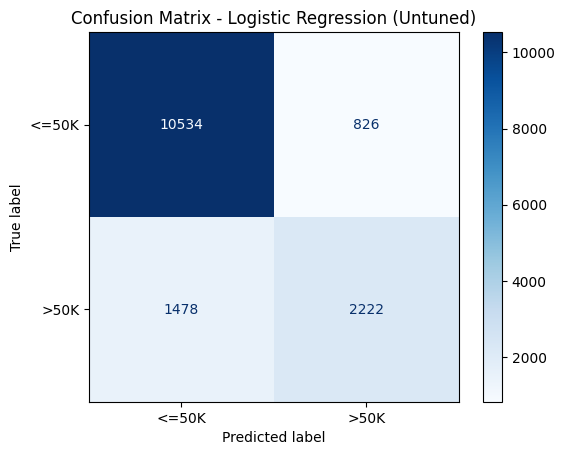

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     11360
        >50K       0.73      0.60      0.66      3700

    accuracy                           0.85     15060
   macro avg       0.80      0.76      0.78     15060
weighted avg       0.84      0.85      0.84     15060

ROC-AUC: 0.9030837576132471


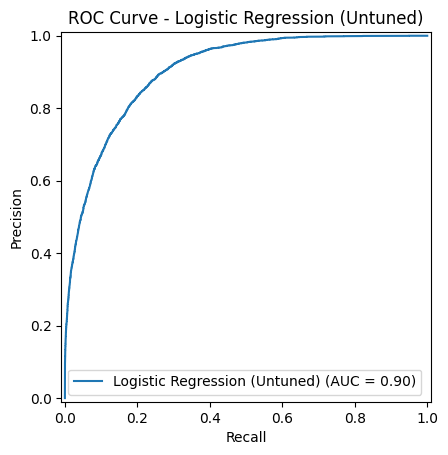

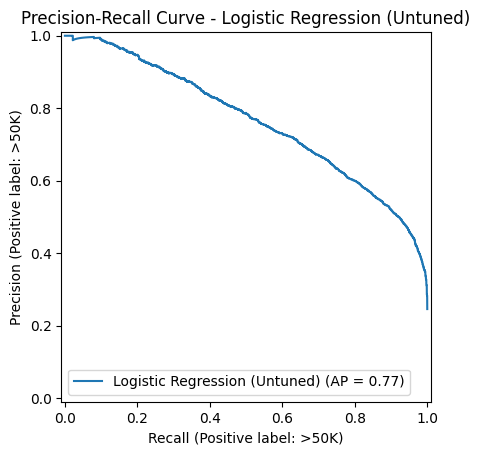

Training time: 0.09805583953857422 seconds
Prediction time: 0.011334896087646484 seconds


In [15]:
# 1. Training and prediction with timing
start_train = time.time()
pipe_lr_untuned.fit(train.drop('income', axis=1), train['income'])
end_train = time.time()
lr_train_time_untuned = end_train - start_train

start_pred = time.time()
pred_lr_untuned = pipe_lr_untuned.predict(test.drop('income', axis=1))
end_pred = time.time()
lr_pred_time_untuned = end_pred - start_pred

# 2. Standalone metrics (set pos_label to your positive class string)
acc_lr_untuned = accuracy_score(test['income'], pred_lr_untuned)
prec_lr_untuned = precision_score(test['income'], pred_lr_untuned, average='binary', pos_label='>50K')
recall_lr_untuned = recall_score(test['income'], pred_lr_untuned, average='binary', pos_label='>50K')
f1_lr_untuned = f1_score(test['income'], pred_lr_untuned, average='binary', pos_label='>50K')
print(f"Accuracy: {acc_lr_untuned:.2f}")
print(f"Precision: {prec_lr_untuned:.2f}")
print(f"Recall: {recall_lr_untuned:.2f}")
print(f"F1-score: {f1_lr_untuned:.2f}")

# 3. Confusion matrix
cm_lr_untuned = confusion_matrix(test['income'], pred_lr_untuned, labels=['<=50K', '>50K'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_untuned, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Untuned)")
plt.show()

# 4. Classification report 
print('Classification Report:')
print(classification_report(test['income'], pred_lr_untuned))

# 5. ROC-AUC
if len(set(test['income'])) == 2:
    lr_roc_auc_untuned = roc_auc_score(test['income'], pipe_lr_untuned.predict_proba(test.drop('income', axis=1))[:,1])
    print('ROC-AUC:', lr_roc_auc_untuned)

    RocCurveDisplay.from_estimator(
    pipe_lr_untuned,  
    test.drop('income', axis=1),
    test['income'],
    name="Logistic Regression (Untuned)"
)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("ROC Curve - Logistic Regression (Untuned)")
plt.legend()
plt.show()

# 6. PR Curve
PrecisionRecallDisplay.from_estimator(
    pipe_lr_untuned,
    test.drop('income', axis=1),
    test['income'],
    name="Logistic Regression (Untuned)"
)
plt.title("Precision-Recall Curve - Logistic Regression (Untuned)")
plt.show()

# 7. Print timing
print('Training time:', lr_train_time_untuned, 'seconds')
print('Prediction time:', lr_pred_time_untuned, 'seconds')

#### 6.2 Predictions and Evaluate Performance (Logistic Regression - Tuned)

Accuracy: 0.81
Precision: 0.57
Recall: 0.84
F1-score: 0.68


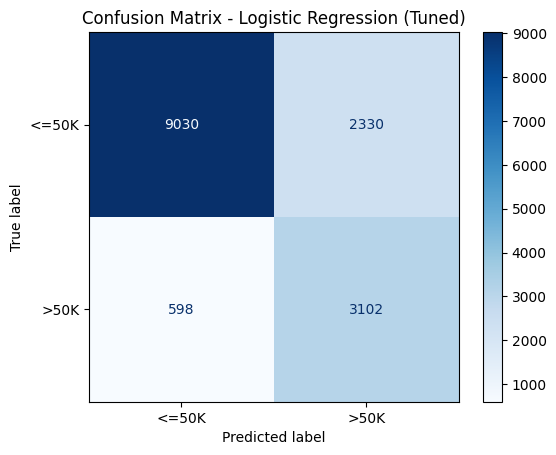

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.94      0.79      0.86     11360
        >50K       0.57      0.84      0.68      3700

    accuracy                           0.81     15060
   macro avg       0.75      0.82      0.77     15060
weighted avg       0.85      0.81      0.82     15060

ROC-AUC: 0.9025562309668823


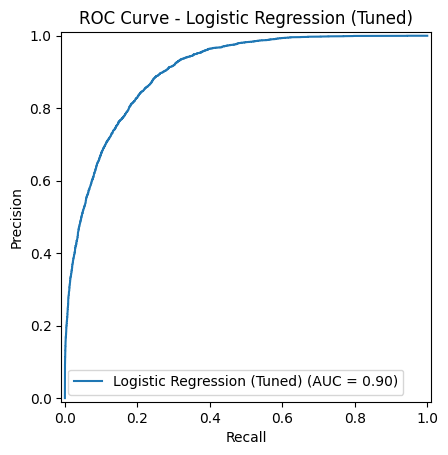

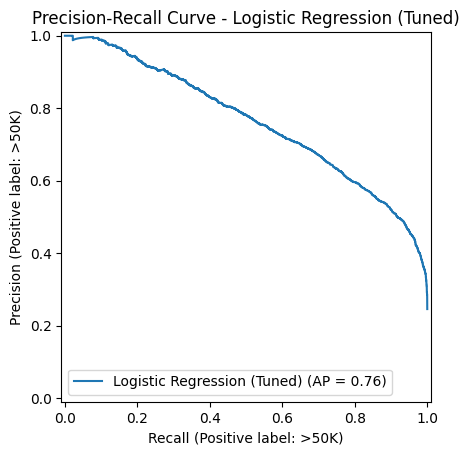

Training time: 0.1076819896697998 seconds
Prediction time: 0.011342048645019531 seconds


In [16]:
# 1. Training and prediction with timing
start_train = time.time()
pipe_lr_tuned.fit(train.drop('income', axis=1), train['income'])
end_train = time.time()
lr_train_time_tuned = end_train - start_train

start_pred = time.time()
pred_lr_tuned = pipe_lr_tuned.predict(test.drop('income', axis=1))
end_pred = time.time()
lr_pred_time_tuned = end_pred - start_pred

# 2. Standalone metrics 
acc_lr_tuned = accuracy_score(test['income'], pred_lr_tuned)
prec_lr_tuned = precision_score(test['income'], pred_lr_tuned, average='binary', pos_label='>50K')
recall_lr_tuned = recall_score(test['income'], pred_lr_tuned, average='binary', pos_label='>50K')
f1_lr_tuned = f1_score(test['income'], pred_lr_tuned, average='binary', pos_label='>50K')
print(f"Accuracy: {acc_lr_tuned:.2f}")
print(f"Precision: {prec_lr_tuned:.2f}")
print(f"Recall: {recall_lr_tuned:.2f}")
print(f"F1-score: {f1_lr_tuned:.2f}")

# 3. Confusion matrix
cm_lr_tuned = confusion_matrix(test['income'], pred_lr_tuned, labels=['<=50K', '>50K'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_tuned, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Tuned)")
plt.show()

# 4. Classification report 

print('Classification Report:')
print(classification_report(test['income'], pred_lr_tuned))

# 5. ROC-AUC 
if len(set(test['income'])) == 2:
    lr_roc_auc_tuned = roc_auc_score(test['income'], pipe_lr_tuned.predict_proba(test.drop('income', axis=1))[:,1])
    print('ROC-AUC:', lr_roc_auc_tuned)

    RocCurveDisplay.from_estimator(
    pipe_lr_tuned,  
    test.drop('income', axis=1),
    test['income'],
    name="Logistic Regression (Tuned)"
)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("ROC Curve - Logistic Regression (Tuned)")
plt.legend()
plt.show()

# 6. PR Curve
PrecisionRecallDisplay.from_estimator(
    pipe_lr_tuned,
    test.drop('income', axis=1),
    test['income'],
    name="Logistic Regression (Tuned)"
)
plt.title("Precision-Recall Curve - Logistic Regression (Tuned)")
plt.show()

# 7. Print timing
print('Training time:', lr_train_time_tuned, 'seconds')
print('Prediction time:', lr_pred_time_tuned, 'seconds')

#### 6.3 Predictions and Evaluate Performance (Random Forest - Untuned)

Accuracy: 0.84
Precision: 0.69
Recall: 0.62
F1-score: 0.65


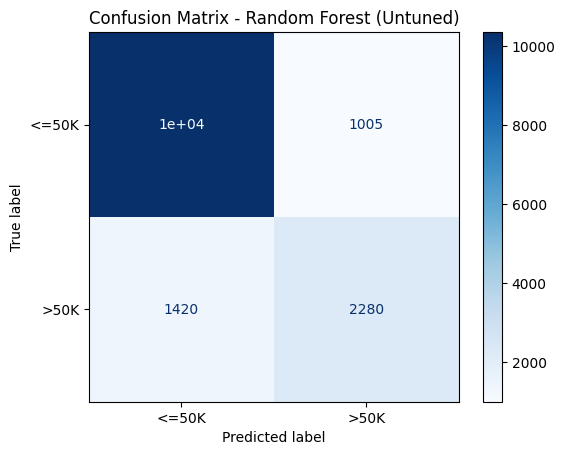

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.90     11360
        >50K       0.69      0.62      0.65      3700

    accuracy                           0.84     15060
   macro avg       0.79      0.76      0.77     15060
weighted avg       0.83      0.84      0.84     15060

ROC-AUC: 0.8862277907308717


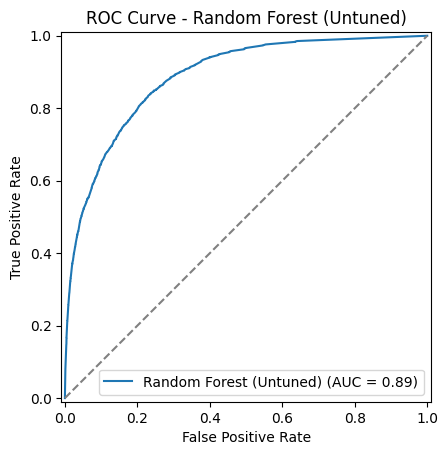

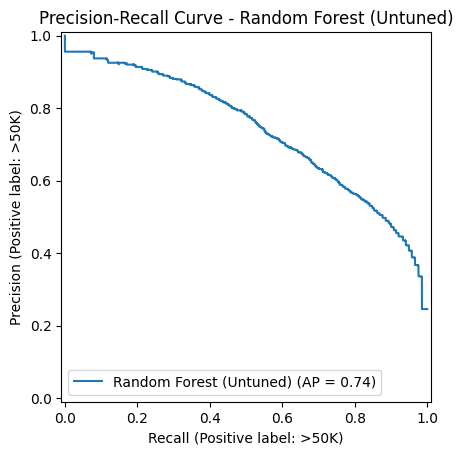

Training time: 6.843716859817505 seconds
Prediction time: 0.14595508575439453 seconds


In [17]:
# 1. Training and prediction with timing
start_train = time.time()
pipe_rf_untuned.fit(train.drop('income', axis=1), train['income'])
end_train = time.time()
rf_train_time_untuned = end_train - start_train

start_pred = time.time()
pred_rf_untuned = pipe_rf_untuned.predict(test.drop('income', axis=1))
end_pred = time.time()
rf_pred_time_untuned = end_pred - start_pred

# 2. Standalone metrics 
acc_rf_untuned = accuracy_score(test['income'], pred_rf_untuned)
prec_rf_untuned = precision_score(test['income'], pred_rf_untuned, average='binary', pos_label='>50K')
recall_rf_untuned = recall_score(test['income'], pred_rf_untuned, average='binary', pos_label='>50K')
f1_rf_untuned = f1_score(test['income'], pred_rf_untuned, average='binary', pos_label='>50K')
print(f"Accuracy: {acc_rf_untuned:.2f}")
print(f"Precision: {prec_rf_untuned:.2f}")
print(f"Recall: {recall_rf_untuned:.2f}")
print(f"F1-score: {f1_rf_untuned:.2f}")

# 3. Confusion matrix
cm_rf_untuned = confusion_matrix(test['income'], pred_rf_untuned, labels=['<=50K', '>50K'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_untuned, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Untuned)")
plt.show()

# 4. Classification report
print('Classification Report:')
print(classification_report(test['income'], pred_rf_untuned))

# 5. ROC-AUC (if binary classification)
if len(set(test['income'])) == 2:
    rf_roc_auc_untuned = roc_auc_score(test['income'], pipe_rf_untuned.predict_proba(test.drop('income', axis=1))[:,1])
    print('ROC-AUC:', rf_roc_auc_untuned)

RocCurveDisplay.from_estimator(
    pipe_rf_untuned,
    test.drop('income', axis=1),
    test['income'],
    name="Random Forest (Untuned)"
)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Untuned)")
plt.legend()
plt.show()

# 6. PR Curve
PrecisionRecallDisplay.from_estimator(
    pipe_rf_untuned,
    test.drop('income', axis=1),
    test['income'],
    name="Random Forest (Untuned)"
)
plt.title("Precision-Recall Curve - Random Forest (Untuned)")
plt.show()

# 7. Print timing
print('Training time:', rf_train_time_untuned, 'seconds')
print('Prediction time:', rf_pred_time_untuned, 'seconds')

#### 6.4 Predictions and Evaluate Performance (Random Forest - Tuned)

Accuracy: 0.83
Precision: 0.61
Recall: 0.82
F1-score: 0.70


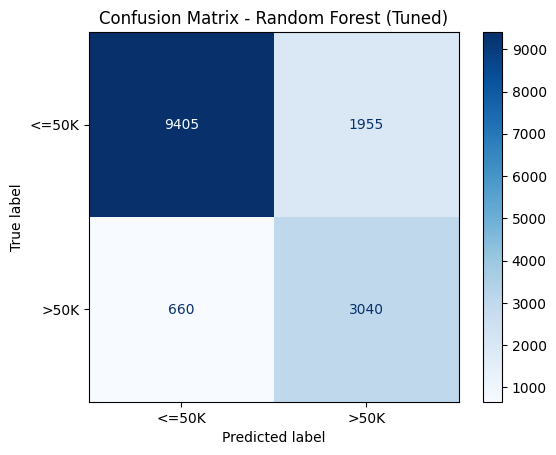

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.93      0.83      0.88     11360
        >50K       0.61      0.82      0.70      3700

    accuracy                           0.83     15060
   macro avg       0.77      0.82      0.79     15060
weighted avg       0.85      0.83      0.83     15060

ROC-AUC: 0.9105256352303006


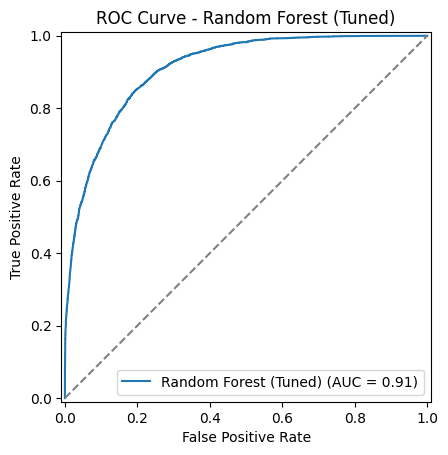

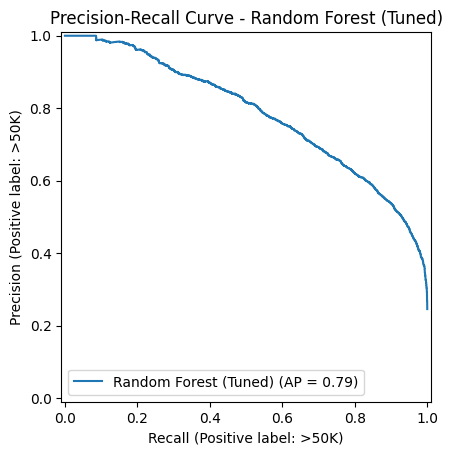

Training time: 3.25437068939209 seconds
Prediction time: 0.0995488166809082 seconds


In [18]:
# 1. Training and prediction with timing
start_train = time.time()
pipe_rf_tuned.fit(train.drop('income', axis=1), train['income'])
end_train = time.time()
rf_train_time_tuned = end_train - start_train

start_pred = time.time()
pred_rf_tuned = pipe_rf_tuned.predict(test.drop('income', axis=1))
end_pred = time.time()
rf_pred_time_tuned = end_pred - start_pred

# 2. Standalone metrics
acc_rf_tuned = accuracy_score(test['income'], pred_rf_tuned)
prec_rf_tuned = precision_score(test['income'], pred_rf_tuned, average='binary', pos_label='>50K')
recall_rf_tuned = recall_score(test['income'], pred_rf_tuned, average='binary', pos_label='>50K')
f1_rf_tuned = f1_score(test['income'], pred_rf_tuned, average='binary', pos_label='>50K')
print(f"Accuracy: {acc_rf_tuned:.2f}")
print(f"Precision: {prec_rf_tuned:.2f}")
print(f"Recall: {recall_rf_tuned:.2f}")
print(f"F1-score: {f1_rf_tuned:.2f}")

# 3. Confusion matrix
cm_rf_tuned = confusion_matrix(test['income'], pred_rf_tuned, labels=['<=50K', '>50K'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tuned, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Tuned)")
plt.show()

# 4. Classification report 
print('Classification Report:')
print(classification_report(test['income'], pred_rf_tuned))

# 5. ROC-AUC
if len(set(test['income'])) == 2:
    rf_roc_auc_tuned = roc_auc_score(test['income'], pipe_rf_tuned.predict_proba(test.drop('income', axis=1))[:,1])
    print('ROC-AUC:', rf_roc_auc_tuned)

    RocCurveDisplay.from_estimator(
    pipe_rf_tuned,
    test.drop('income', axis=1),
    test['income'],
    name="Random Forest (Tuned)"
)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Tuned)")
plt.legend()
plt.show()

# 6. PR Curve
PrecisionRecallDisplay.from_estimator(
    pipe_rf_tuned,
    test.drop('income', axis=1),
    test['income'],
    name="Random Forest (Tuned)"
)
plt.title("Precision-Recall Curve - Random Forest (Tuned)")
plt.show()

# 7. Print timing
print('Training time:', rf_train_time_tuned, 'seconds')
print('Prediction time:', rf_pred_time_tuned, 'seconds')

### 7. Model Comparison
#### 7.1 Untuned vs Tuned Performance Comparison (Both Logistic Regression and Random Forest)

In [ ]:
performance_summary = pd.DataFrame({
    'Model': ['Logistic Regression (Untuned)', 'Logistic Regression (Tuned)',
              'Random Forest (Untuned)', 'Random Forest (Tuned)'],
    'Accuracy': [
        accuracy_score(test['income'], pred_lr_untuned),
        accuracy_score(test['income'], pred_lr_tuned),
        accuracy_score(test['income'], pred_rf_untuned),
        accuracy_score(test['income'], pred_rf_tuned)
    ],
    'Precision': [
        precision_score(test['income'], pred_lr_untuned, pos_label='>50K'),
        precision_score(test['income'], pred_lr_tuned, pos_label='>50K'),
        precision_score(test['income'], pred_rf_untuned, pos_label='>50K'),
        precision_score(test['income'], pred_rf_tuned, pos_label='>50K')
    ],
    'Recall': [
        recall_score(test['income'], pred_lr_untuned, pos_label='>50K'),
        recall_score(test['income'], pred_lr_tuned, pos_label='>50K'),
        recall_score(test['income'], pred_rf_untuned, pos_label='>50K'),
        recall_score(test['income'], pred_rf_tuned, pos_label='>50K')
    ],
    'F1-Score': [
        f1_score(test['income'], pred_lr_untuned, pos_label='>50K'),
        f1_score(test['income'], pred_lr_tuned, pos_label='>50K'),
        f1_score(test['income'], pred_rf_untuned, pos_label='>50K'),
        f1_score(test['income'], pred_rf_tuned, pos_label='>50K')
    ],
    'Training Time (s)': [lr_train_time_untuned, lr_train_time_tuned, rf_train_time_untuned, rf_train_time_tuned],
    'Prediction Time (s)': [lr_pred_time_untuned, lr_pred_time_tuned, rf_pred_time_untuned, rf_pred_time_tuned]
})


performance_summary = performance_summary.round({
    'Accuracy': 4,
    'Precision': 4,
    'Recall': 4,
    'F1-Score': 4,
    'Training Time (s)': 4,
    'Prediction Time (s)': 4
})

print('=== Summary Table ===')
print(performance_summary)

=== Summary Table ===
                           Model  Accuracy  Precision  Recall  F1-Score  \
0  Logistic Regression (Untuned)    0.8470     0.7290  0.6005    0.6586   
1    Logistic Regression (Tuned)    0.8056     0.5711  0.8384    0.6794   
2        Random Forest (Untuned)    0.8390     0.6941  0.6162    0.6528   
3          Random Forest (Tuned)    0.8264     0.6086  0.8216    0.6993   

   Training Time (s)  Prediction Time (s)  
0             0.0981               0.0113  
1             0.1077               0.0113  
2             6.8437               0.1460  
3             3.2544               0.0995  


#### 7.2 Logistic Regression vs Random Forest Figure (Tuned and Untuned) (ROC and PR)

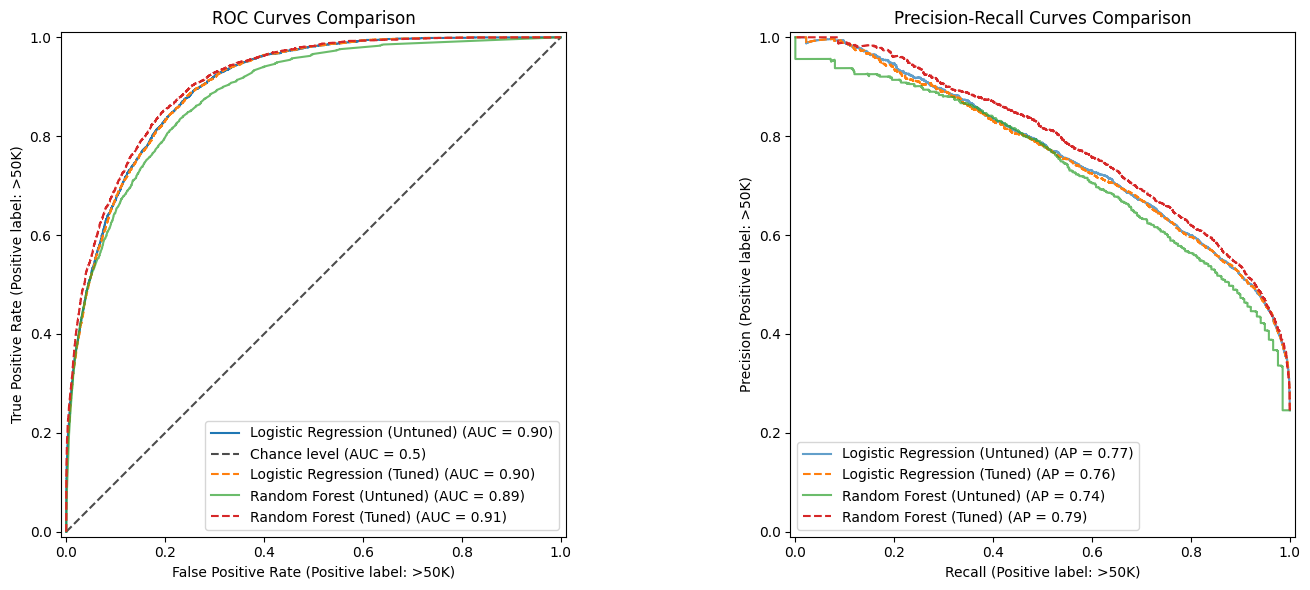

In [ ]:
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(15, 6))

RocCurveDisplay.from_estimator(
    pipe_lr_untuned,
    test.drop('income', axis=1),
    test['income'],
    name="Logistic Regression (Untuned)",
    ax=ax_roc,
    plot_chance_level=True
)

RocCurveDisplay.from_estimator(
    pipe_lr_tuned,
    test.drop('income', axis=1),
    test['income'],
    name="Logistic Regression (Tuned)",
    ax=ax_roc,
    plot_chance_level=False
)

RocCurveDisplay.from_estimator(
    pipe_rf_untuned,
    test.drop('income', axis=1),
    test['income'],
    name="Random Forest (Untuned)",
    ax=ax_roc,
    plot_chance_level=False
)

RocCurveDisplay.from_estimator(
    pipe_rf_tuned,
    test.drop('income', axis=1),
    test['income'],
    name="Random Forest (Tuned)",
    ax=ax_roc,
    plot_chance_level=False
)


lines = ax_roc.get_lines()
if len(lines) >= 4:
    lines[1].set_alpha(0.7) 
    lines[2].set_linestyle('--')  
    lines[3].set_alpha(0.7)  
    lines[4].set_linestyle('--') 

ax_roc.set_title("ROC Curves Comparison")
ax_roc.legend(loc='lower right')

# Precision-Recall Curves - All models
PrecisionRecallDisplay.from_estimator(
    pipe_lr_untuned,
    test.drop('income', axis=1),
    test['income'],
    name="Logistic Regression (Untuned)",
    ax=ax_pr
)

PrecisionRecallDisplay.from_estimator(
    pipe_lr_tuned,
    test.drop('income', axis=1),
    test['income'],
    name="Logistic Regression (Tuned)",
    ax=ax_pr
)

PrecisionRecallDisplay.from_estimator(
    pipe_rf_untuned,
    test.drop('income', axis=1),
    test['income'],
    name="Random Forest (Untuned)",
    ax=ax_pr
)

PrecisionRecallDisplay.from_estimator(
    pipe_rf_tuned,
    test.drop('income', axis=1),
    test['income'],
    name="Random Forest (Tuned)",
    ax=ax_pr
)

# Manually style the PR curve lines
pr_lines = ax_pr.get_lines()
if len(pr_lines) >= 4:
    pr_lines[0].set_alpha(0.7)  # LR Untuned
    pr_lines[1].set_linestyle('--')  # LR Tuned
    pr_lines[2].set_alpha(0.7)  # RF Untuned
    pr_lines[3].set_linestyle('--')  # RF Tuned

ax_pr.set_title("Precision-Recall Curves Comparison")
ax_pr.legend(loc='lower left')

plt.tight_layout()
plt.show()

# Print summary of ROC-AUC scores for comparison
lr_untuned_auc = roc_auc_score(test['income'], pipe_lr_untuned.predict_proba(test.drop('income', axis=1))[:,1])
lr_tuned_auc = roc_auc_score(test['income'], pipe_lr_tuned.predict_proba(test.drop('income', axis=1))[:,1])
rf_untuned_auc = roc_auc_score(test['income'], pipe_rf_untuned.predict_proba(test.drop('income', axis=1))[:,1])
rf_tuned_auc = roc_auc_score(test['income'], pipe_rf_tuned.predict_proba(test.drop('income', axis=1))[:,1])

#### 7.3 Logistic Regression vs Random Forest Figure (Tuned and Untuned) (Confussion Matrix)

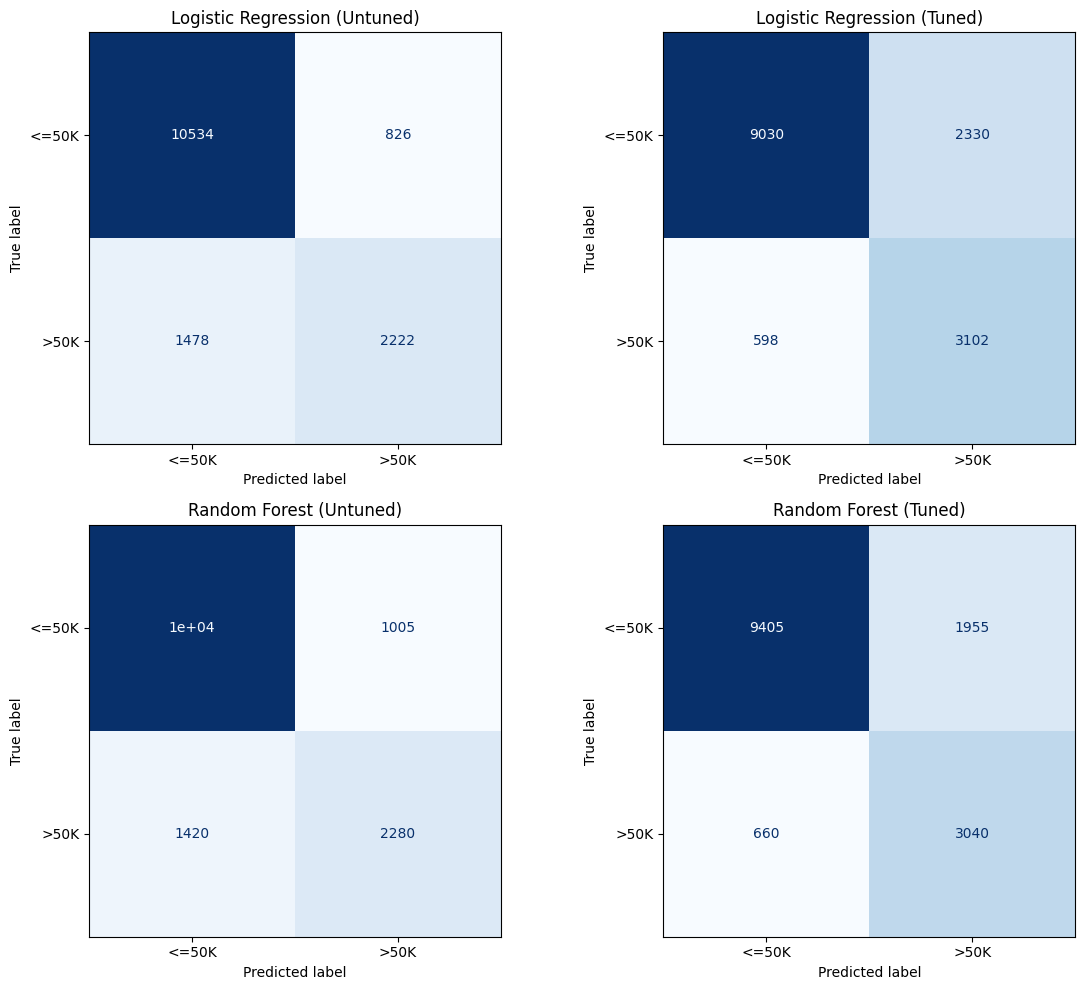

In [24]:
models = {
    'Logistic Regression (Untuned)': pipe_lr_untuned,
    'Logistic Regression (Tuned)': pipe_lr_tuned,
    'Random Forest (Untuned)': pipe_rf_untuned,
    'Random Forest (Tuned)': pipe_rf_tuned
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.ravel(), models.items()):
    y_pred = model.predict(test.drop('income', axis=1))
    cm = confusion_matrix(test['income'], y_pred, labels=['<=50K', '>50K'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()